## Prepare the environment

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-d4o3766f
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-d4o3766f
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=596f6cb558f358c9bd365bc3aa750e22ca9b1188ccae8fc0f8d6fd273b47b166
  Stored in directory: /tmp/pip-ephem-wheel-cache-qa4dt04e/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00


### Install torch
If you have torch in your environment, do  not run this part

In [ ]:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu117

## Download
Download the pretrained model and demo data

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://finspire13.github.io/jimaging-02-00031-v2.jpg

--2023-09-13 12:52:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.15, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   152MB/s    in 15s     

2023-09-13 12:52:16 (167 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

--2023-09-13 12:52:16--  https://finspire13.github.io/jimaging-02-00031-v2.jpg
Resolving finspire13.github.io (finspire13.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to finspire13.github.io (finspire13.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7798 (7.6K) [image/jpeg]
Saving to: ‘jimaging-02-00031-v2.jpg’

## Import
import the important packages

In [ ]:
import cv2  # type: ignore
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import argparse
import json
import os
from typing import Any, Dict, List

## Add parameters
Adding parameters helps users to personalize some parameters (e.g. the path of the image to be segmented, etc.) in the code without making changes to the code.

In [ ]:
args_ = {
    'input': '/content/jimaging-02-00031-v2.jpg', #Your input root
    'output': '/content/masks', #Your output root
    'model_type': 'vit_h', #The type of model you choose, in['default', 'vit_h', 'vit_l', 'vit_b']
    'checkpoint': '/content/sam_vit_h_4b8939.pth', #The root to your pretrained model
    'device': 'cuda', #The device to run generation on
    'convert_to_rle': False, # Output type

    'points_per_batch': 64, #Tpe: int. How many input points to process simultaneously in one batch.
    'points_per_side': 32, #Tpe: int. How many input points to sample in one side.
    'pred_iou_thresh': 0.88, #Type: float. Exclude masks with a stability score lower than this threshold.
    'stability_score_thresh': 0.95,
    'stability_score_offset': 1.0, #Type: float. Larger values perturb the mask more when measuring stability score.
    'box_nms_thresh': 0.7, #Type: float. The overlap threshold for excluding a duplicate mask.
    'crop_n_layers': 0, #Type: int. The value sets how many different scales to crop at. If >0, mask generation is run on smaller crops of the image to generate more masks.
    'crop_nms_thresh': 0.7, #Type: float. The overlap threshold for excluding duplicate masks across different crops.
    'crop_overlap_ratio': None, #Type: int. Larger numbers mean image crops will overlap more.
    'crop_n_points_downscale_factor': 1, #Type: int. The number of points-per-side in each layer of crop is reduced by this factor."
    'min_mask_region_area': 0, #Type: int. Disconnected mask regions or holes with area smaller than this value in pixels are removed by postprocessing.
}

## Define the functions

Define the main functions for using the SAM tools.

In [ ]:
def get_amg_kwargs(args):
    amg_kwargs = {
        "points_per_side": args.points_per_side,
        "points_per_batch": args.points_per_batch,
        "pred_iou_thresh": args.pred_iou_thresh,
        "stability_score_thresh": args.stability_score_thresh,
        "stability_score_offset": args.stability_score_offset,
        "box_nms_thresh": args.box_nms_thresh,
        "crop_n_layers": args.crop_n_layers,
        "crop_nms_thresh": args.crop_nms_thresh,
        "crop_overlap_ratio": args.crop_overlap_ratio,
        "crop_n_points_downscale_factor": args.crop_n_points_downscale_factor,
        "min_mask_region_area": args.min_mask_region_area,
    }
    amg_kwargs = {k: v for k, v in amg_kwargs.items() if v is not None}
    return amg_kwargs

def write_masks_to_folder(masks: List[Dict[str, Any]], path: str) -> None:
    header = "id,area,bbox_x0,bbox_y0,bbox_w,bbox_h,point_input_x,point_input_y,predicted_iou,stability_score,crop_box_x0,crop_box_y0,crop_box_w,crop_box_h"  # noqa
    metadata = [header]
    for i, mask_data in enumerate(masks):
        mask = mask_data["segmentation"]
        filename = f"{i}.png"
        cv2.imwrite(os.path.join(path, filename), mask * 255)
        mask_metadata = [
            str(i),
            str(mask_data["area"]),
            *[str(x) for x in mask_data["bbox"]],
            *[str(x) for x in mask_data["point_coords"][0]],
            str(mask_data["predicted_iou"]),
            str(mask_data["stability_score"]),
            *[str(x) for x in mask_data["crop_box"]],
        ]
        row = ",".join(mask_metadata)
        metadata.append(row)
    metadata_path = os.path.join(path, "metadata.csv")
    with open(metadata_path, "w") as f:
        f.write("\n".join(metadata))


def process_SAM(args: argparse.Namespace) -> None:
    print("Loading model...")
    sam = sam_model_registry[args.model_type](checkpoint=args.checkpoint)
    _ = sam.to(device=args.device)
    output_mode = "coco_rle" if args.convert_to_rle else "binary_mask"
    amg_kwargs = get_amg_kwargs(args)
    generator = SamAutomaticMaskGenerator(sam, output_mode=output_mode, **amg_kwargs)

    if not os.path.isdir(args.input):
        targets = [args.input]
    else:
        targets = [
            f for f in os.listdir(args.input) if not os.path.isdir(os.path.join(args.input, f))
        ]
        targets = [os.path.join(args.input, f) for f in targets]

    os.makedirs(args.output, exist_ok=True)

    for t in targets:
        print(f"Processing '{t}'...")
        image = cv2.imread(t)
        if image is None:
            print(f"Could not load '{t}' as an image, skipping...")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        masks = generator.generate(image)

        base = os.path.basename(t)
        base = os.path.splitext(base)[0]
        save_base = os.path.join(args.output, base)
        if output_mode == "binary_mask":
            os.makedirs(save_base, exist_ok=False)
            write_masks_to_folder(masks, save_base)
        else:
            save_file = save_base + ".json"
            with open(save_file, "w") as f:
                json.dump(masks, f)
    print("Done!")


## Using SAM tools with given parameters
Defining parameters and calling functions to use SAM tools

In [ ]:
args = argparse.Namespace(**args_)
process_SAM(args)

Loading model...
Processing '/content/jimaging-02-00031-v2.jpg'...
Done!


##Plot the mask

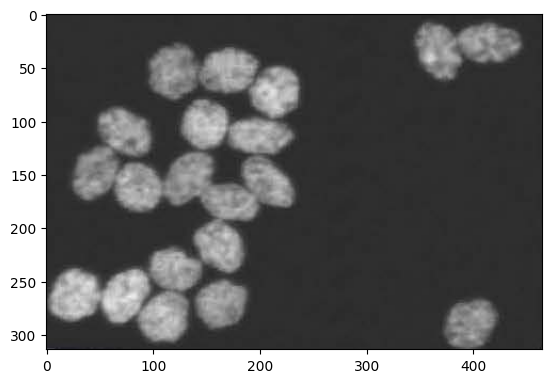

20


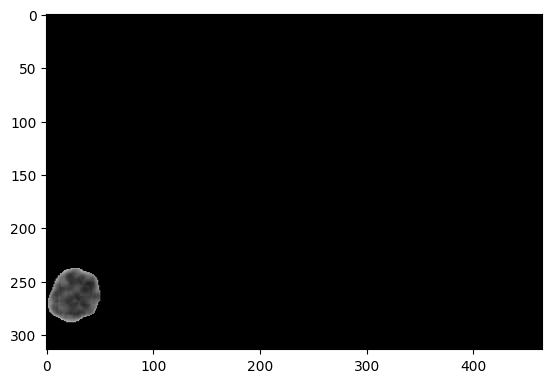

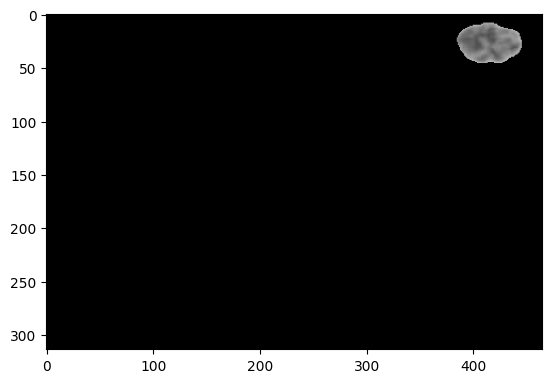

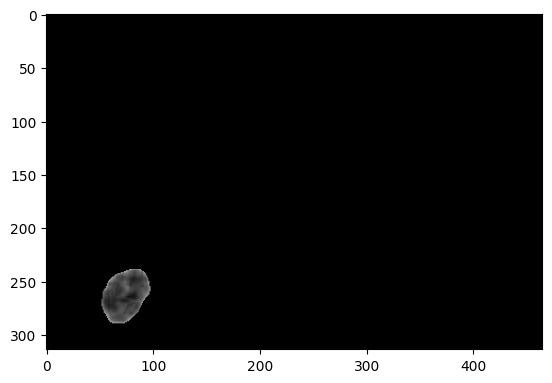

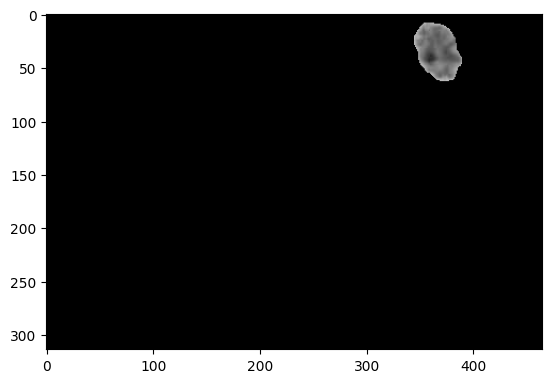

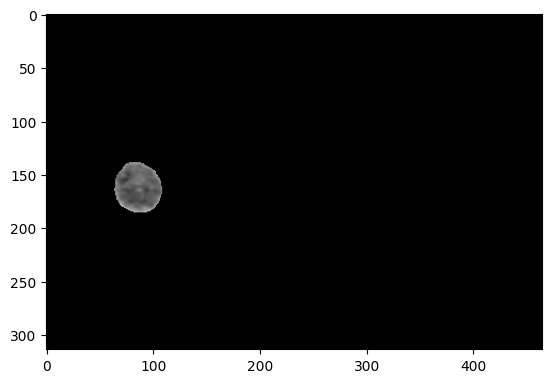

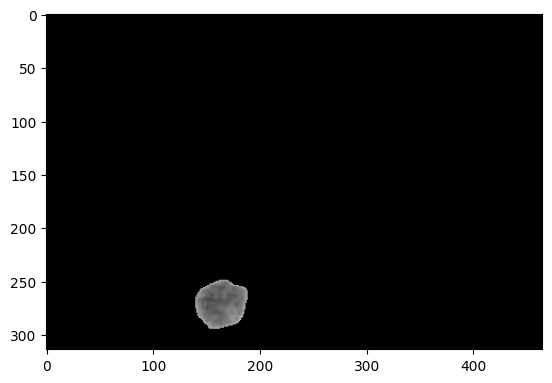

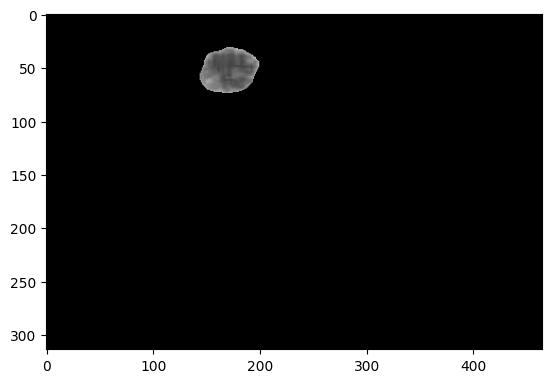

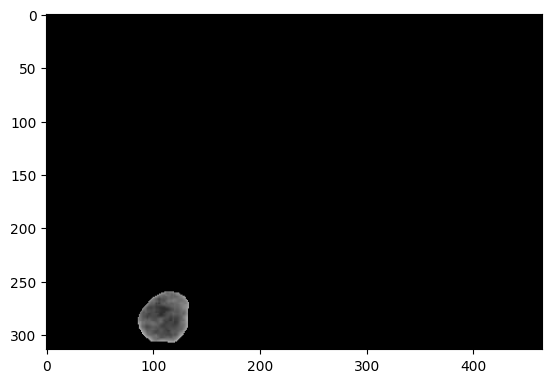

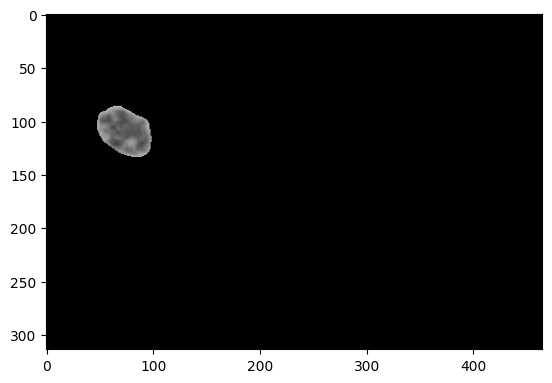

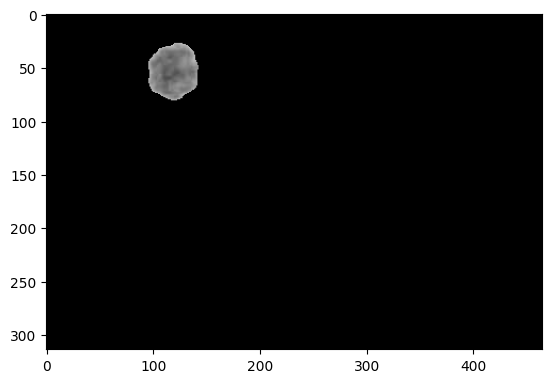

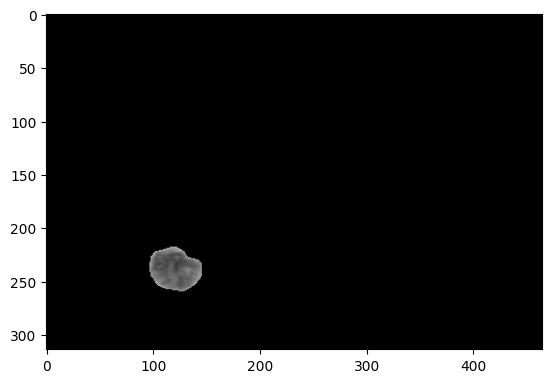

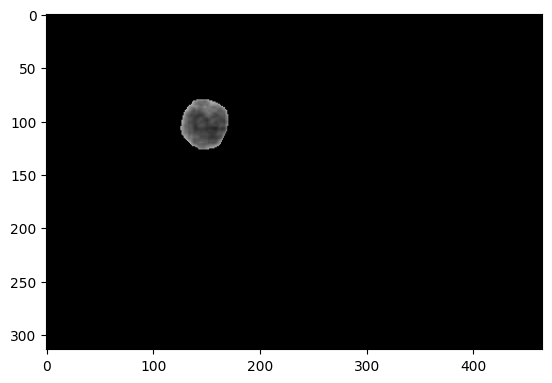

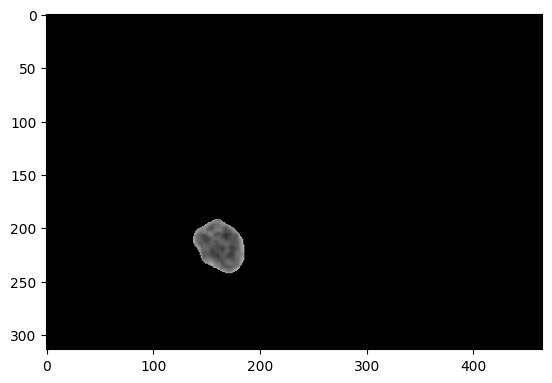

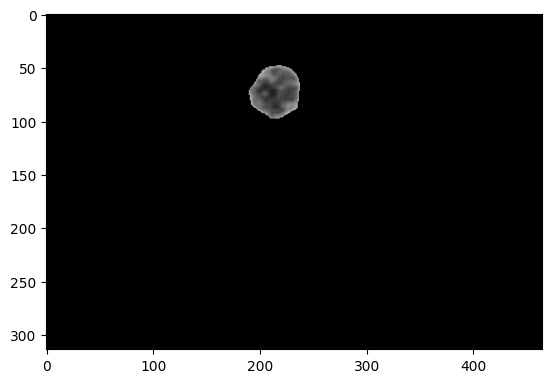

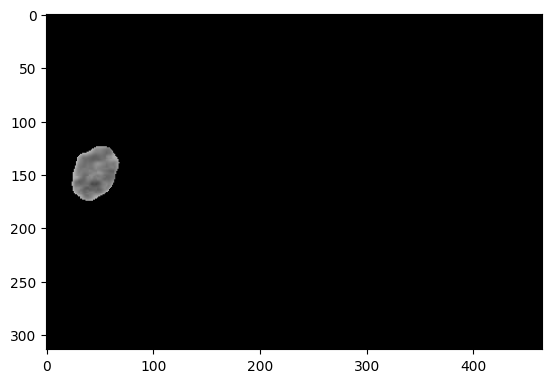

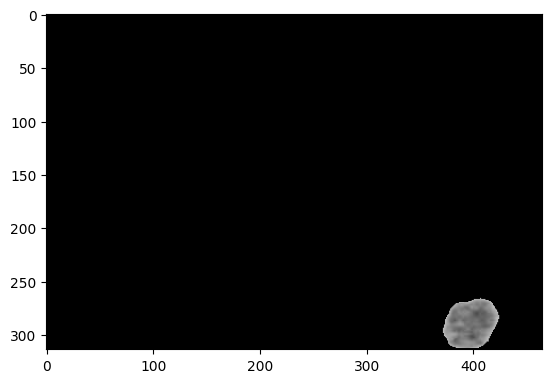

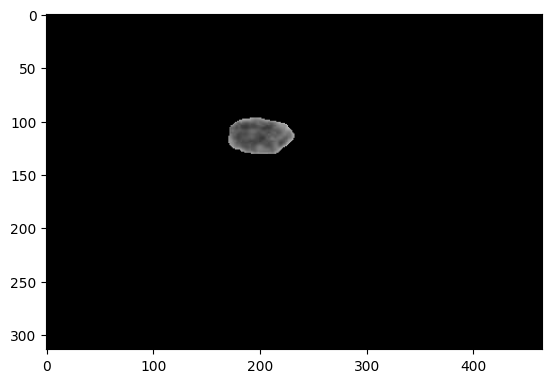

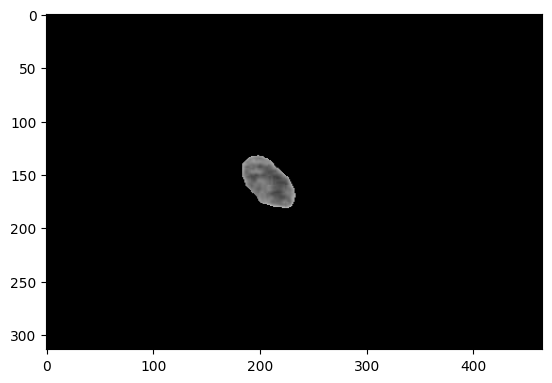

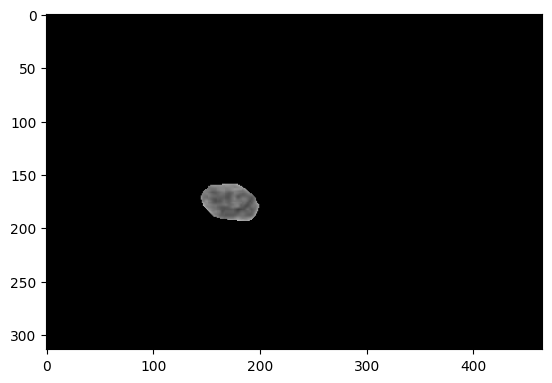

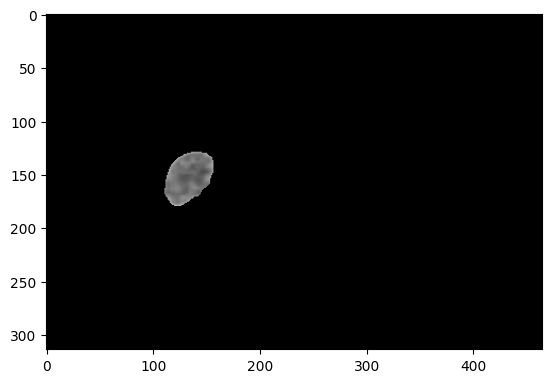

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread(args_['input'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
plt.close()

meta_data = pd.read_csv('/content/masks/jimaging-02-00031-v2/metadata.csv')
selected_mask_ids = [i[0] for i in meta_data.values if i[1] > 500 and i[1] < 2500] # filtered by area
print(len(selected_mask_ids))

mask_paths = [str(int(i)) + '.png' for i in selected_mask_ids]
for mask_path in mask_paths:
    mask_path = os.path.join('/content/masks/jimaging-02-00031-v2', mask_path)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    plt.imshow(mask * image)
    plt.show()
    plt.close()

In [ ]:
!cat /content/masks/jimaging-02-00031-v2/metadata.csv

id,area,bbox_x0,bbox_y0,bbox_w,bbox_h,point_input_x,point_input_y,predicted_iou,stability_score,crop_box_x0,crop_box_y0,crop_box_w,crop_box_h
0,106118,0,0,464,312,312.421875,63.78125,1.0255409479141235,0.9509732127189636,0,0,465,314
1,1926,2,238,48,50,21.796875,250.21875,1.0031111240386963,0.9860752820968628,0,0,465,314
2,1801,385,8,60,37,385.078125,24.53125,1.002483606338501,0.9856985807418823,0,0,465,314
3,1707,52,239,45,50,65.390625,250.21875,1.000313639640808,0.9906759858131409,0,0,465,314
4,1791,345,8,44,54,370.546875,53.96875,1.0000239610671997,0.9806308746337891,0,0,465,314
5,3682,345,8,100,54,428.671875,24.53125,0.9996397495269775,0.9787577390670776,0,0,465,314
6,1665,64,139,44,46,79.921875,181.53125,0.9989917874336243,0.9821534752845764,0,0,465,314
7,1750,140,249,48,45,152.578125,289.46875,0.9985267519950867,0.9875141978263855,0,0,465,314
8,1846,144,31,55,42,152.578125,63.78125,0.9983319044113159,0.9859989285469055,0,0,465,314
9,1815,86,260,47,47,123.515625,269.84375,0.9977577

In [ ]:
!rm -r /content/masks/jimaging-02-00031-v2